In [1]:
! pip -q install torchtext==0.6.0
! pip -q install pyvi
! pip -q install https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz
! python -m spacy link vi_spacy_model vi_spacy_model

import nltk
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.4 MB/s eta 0:00:00
  ERROR: HTTP error 404 while getting https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz
ERROR: Could not install requirement https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz because of HTTP error 404 Client Error: Not Found for url: https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz for URL https://github.com/trungtv/vi_spacy/raw/master/packages/vi_spacy_model-0.2.1/dist/vi_spacy_model-0.2.1.tar.gz
⚠ As of spaCy v3.0, model symlinks are not supported anymore. You can
load trained pipeline packages using their full names or from a directory
path.


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
import math

# Embedding Layer with Position Encoding



In [6]:
class Embedder(nn.Module):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model

    self.embed = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embed(x)

embed =  Embedder(100, 512)(torch.LongTensor([1,2,3,4]))
print(embed.shape)
print(embed)

torch.Size([4, 512])
tensor([[-0.1806, -0.4871,  0.0932,  ..., -0.0576,  1.1686,  1.7167],
        [ 0.3454,  2.0280,  1.4273,  ...,  0.3442, -0.4228,  0.8609],
        [ 0.3474,  1.3048,  0.2739,  ...,  0.7987, -0.0997,  0.7895],
        [ 1.0525,  0.7265, -1.2056,  ..., -0.0692, -1.2687, -0.3873]],
       grad_fn=<EmbeddingBackward0>)


# Phương pháp đề xuất sinusoidal position encoding

In [7]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=200, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_length, d_model)

        # Bảng pe mình vẽ ở trên
        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x*math.sqrt(self.d_model)
        seq_length = x.size(1)

        pe = Variable(self.pe[:, :seq_length], requires_grad=False)

        if x.is_cuda:
            pe.cuda()
        # cộng embedding vector với pe
        x = x + pe
        x = self.dropout(x)

        return x

PositionalEncoder(512)(torch.rand(5, 30, 512)).shape

torch.Size([5, 30, 512])

# Encoder

In [18]:
def attention(q, k, v, mask=None, dropout=None):
    """
    q: batch_size x head x seq_length x d_model
    k: batch_size x head x seq_length x d_model
    v: batch_size x head x seq_length x d_model
    mask: batch_size x 1 x 1 x seq_length
    output: batch_size x head x seq_length x d_model
    """

    # attention score được tính bằng cách nhân q với k
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1) # Thêm 1 chiều vào vị trị 1
        scores = scores.masked_fill(mask==0, -1e9)
    # xong rồi thì chuẩn hóa bằng softmax
    scores = F.softmax(scores, dim=-1) # softmax theo chiều cuối cùng của scores

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores

output, scores = attention(torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512))
print(output.shape)
print(scores.shape)

torch.Size([32, 8, 30, 512])
torch.Size([32, 8, 30, 30])


In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0

        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        # tạo ra 3 ma trận trọng số là q_linear, k_linear, v_linear như hình trên
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        q: batch_size x seq_length x d_model
        k: batch_size x seq_length x d_model
        v: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        bs = q.size(0)
        # nhân ma trận trọng số q_linear, k_linear, v_linear với dữ liệu đầu vào q, k, v
        # ở bước encode các bạn lưu ý rằng q, k, v chỉ là một (xem hình trên)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # tính attention score
        scores, self.attn = attention(q, k, v, mask, self.dropout)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output
MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512)).shape

torch.Size([32, 30, 512])

# Residuals Connection và Normalization Layer

In [27]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [28]:
class FeedForward(nn.Module):
    """ Trong kiến trúc của chúng ta có tầng linear
    """
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [29]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """


        x2 = self.norm_1(x)
        # tính attention value, các bạn để ý q, k, v là giống nhau
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32 , 1, 30)).shape

torch.Size([32, 30, 512])

# Decoder
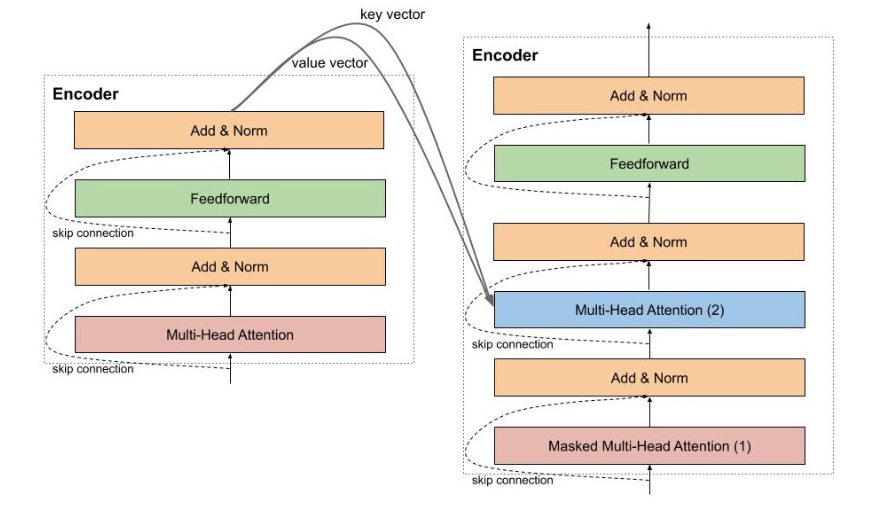

In [30]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: batch_size x seq_length x d_model
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        """
        # Các bạn xem hình trên, kiến trúc mình vẽ với code ở chỗ này tương đương nhau.
        x2 = self.norm_1(x)
        # multihead attention thứ nhất, chú ý các từ ở target
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        # masked mulithead attention thứ 2. k, v là giá trị output của mô hình encoder
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

DecoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

torch.Size([32, 30, 512])

# Cài đặt Encoder

In [37]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    """Một encoder có nhiều encoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

torch.Size([32, 30, 512])

# Cài đặt Decoder

In [38]:
class Decoder(nn.Module):
    """Một decoder có nhiều decoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: batch_size x seq_length
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

Decoder(232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

torch.Size([32, 30, 512])

# Cài đặt Transformer

In [39]:
class Transformer(nn.Module):
    """ Cuối cùng ghép chúng lại với nhau để được mô hình transformer hoàn chỉnh
    """
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x 1 x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

Transformer(232, 232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.LongTensor(32, 30).random_(0, 10),torch.rand(32, 1, 30),torch.rand(32, 1, 30)).shape

torch.Size([32, 30, 232])